# IBM AI Enterprise Workflow Capstone
Files for the IBM AI Enterprise Workflow Capstone project. 

## Part 1

### Case study part 1

At this point in the project, and in any data science project really, it is best to loosly organize your code as libraries and scripts.  Jupyter notebooks are a convenient and powerful tool, but we have mentioned several times that they are not a good place for source code to live.  If you decide to use a notebook for this part, we recommend that it is used to run functions that live within a [python module](https://docs.python.org/3/tutorial/modules.html).

### Deliverable goals

Overall this part of the case study is meant to tell the story of the data by investigating the relationship between the data and the business opportunity.

> (1) Assimilate the business scenario and articulate testable hypotheses.

Take what you have read from the stories and from what you know about the business scenario and, in your own words, carefully re-state the business opportunity.  Given the stated opportunity, enumerate the testable hypotheses.

> (2) State the ideal data to address the business opportunity and clarify the rationale for needing specific data.

Note that this step is carried out **before you read in the data**.  It helps clarify exactly what your are looking for in the data and it helps provide context for what the feature matrix and targets will look like.

3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

From within a Python module there should be a function that reads in the data, attempts to catch common input errors and returns a feature matrix (NumPy array or Pandas DataFrame) that will subsequently be used as a starting point for EDA and modeling.

### Libraries

In [85]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

### Configs

In [2]:
plt.style.use('seaborn')
%matplotlib inline

### Support Functions

In [3]:
def read_files(path, column_dict, inconsistent_col, keys):
    list_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
    sorted_list_files = sorted(list_files)
    df_total = pd.DataFrame(columns = keys)
    for file in sorted_list_files:
        with open(path+file, 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
        for i in inconsistent_col:
            if i in df.columns:
                df = df.rename(columns=column_dict)
        df_total = df_total.append(df, ignore_index=True)
    print(df_total.shape)
    return df_total

In [40]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [43]:
def log_shift(data, shift):
    ts_log = np.log(data)
    ts_log_diff = ts_log - ts_log.shift(shift)
    ts_log_diff = ts_log_diff.dropna()
    ts_log_diff = pd.Series(ts_log_diff.values ,index= ts_log_diff.index)
    return ts_log, ts_log_diff

In [70]:
def fit_ARIMA(ts, order):
    '''
    Fits ARIMA model after log shifting it by 1 unit
    Args: ts-timeseries data
          order-(p,d,q) values
    Output: fitted model alongwith a plot of fitted values and RSS
    '''
    ts_log, ts_log_diff = log_shift(ts, 1)
    model = ARIMA(ts_log, order=(1, 1, 1))
    # model = ARIMA(ts, order=(1, 1, 1))
    results_ARIMA = model.fit(disp=-1)
    # plt.plot(ts_log_diff)
    plt.plot()
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
    return results_ARIMA

def predict_ARIMA(ts, order):
    '''
    Returns the predicted values from ARIMA model
    '''
    results_ARIMA = fit_ARIMA(ts, order)
    predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
    return predictions_ARIM

In [78]:
def make_continuous(df):
    '''
    Makes the data continuos to be compatible with the seasonal_decompose
    function
    '''
    df = df[['price', 'Date']].set_index('Date') # Set Date as index
    df = df.asfreq(freq='1D') # Set the frequency as 1 Day
    ## fill missing values by interpolating
    df['price'].interpolate(inplace = True)
    return df

In [80]:
def decompose(data, col):
    ts_log, ts_log_diff = log_shift(data[col], 1)
    decomposition = seasonal_decompose(ts_log)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    figure(num=None, figsize=(10, 7), dpi=300, facecolor='w', edgecolor='k')
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    return trend, seasonal, residual


### Data Ingestion

In [4]:
path = "C:/Users/Caique/Documents/ai-academy/Capstone/ai-workflow-capstone-master/cs-train/"
columns ={'country': 'country', 'customer_id': 'customer_id',
                       'day': 'day','invoice': 'invoice', 'month': 'month',
                       'total_price': 'price', 'StreamID': 'stream_id',
                        'TimesViewed': 'times_viewed'}
inconsistent_col = ['TimesViewed', 'StreamID', 'total_price']
keys=['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

In [5]:
df = read_files(path, columns, inconsistent_col, keys)
df.head()

(815011, 9)


,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017
1,United Kingdom,NaN,28,489597,11,8.65,22130,1,2017
2,United Kingdom,NaN,28,489597,11,1.70,22132,6,2017
3,United Kingdom,NaN,28,489597,11,1.70,22133,4,2017
4,United Kingdom,NaN,28,489597,11,0.87,22134,1,2017


### Data Processing

In [20]:
df.shape

(815011, 9)

In [16]:
df.dtypes

country          object
customer_id     float64
day              object
invoice          object
month            object
price           float64
stream_id        object
times_viewed     object
year             object
dtype: object

In [6]:
df = df.astype({ "country": str, "day": int,
                            "month": int, "price": float,
                            "times_viewed": int, "year": int})

In [19]:
df.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


In [7]:
df = df[~df['invoice'].str.contains("[a-zA-Z]").fillna(False)]

In [8]:
df_agg = df.groupby(['invoice']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first', 'day':'first',
                                        'month':'first', 'year':'first'}).reset_index()
df_agg.head()

,invoice,times_viewed,price,country,day,month,year
0,489434,103,32.65,United Kingdom,28,11,2017
1,489435,54,10.50,United Kingdom,28,11,2017
2,489436,165,70.88,United Kingdom,28,11,2017
3,489437,145,83.45,United Kingdom,28,11,2017
4,489438,214,44.05,United Kingdom,28,11,2017


In [9]:
df.drop_duplicates(subset ="invoice", 
                     keep = False, inplace = True)

In [10]:
df.columns[df.isnull().any()]

Index(['customer_id'], dtype='object')

In [11]:
df = df[df.customer_id.notna()]

### Exploratory Data Analysis (EDA)

In [13]:
df.columns

Index(['country', 'customer_id', 'day', 'invoice', 'month', 'price',
       'stream_id', 'times_viewed', 'year'],
      dtype='object')

In [20]:
#Contries
df.year.unique()

array([2017, 2018, 2019])

In [16]:
#Contries
df.country.unique()

array(['United Kingdom', 'USA', 'Belgium', 'Denmark', 'Germany', 'EIRE',
       'France', 'Spain', 'Japan', 'Portugal', 'Italy', 'Finland',
       'Nigeria', 'Malta', 'Netherlands', 'Norway', 'Austria', 'Sweden',
       'Cyprus', 'Australia', 'Switzerland', 'Channel Islands',
       'United Arab Emirates', 'Singapore', 'Canada', 'Poland',
       'European Community'], dtype=object)

In [18]:
#Top 10 countries in terms of invoices
df.groupby(['country'])['invoice'].count().sort_values(ascending=False)[0:10]

country
United Kingdom    2136
EIRE                53
Germany             46
France              24
Netherlands         22
Australia           12
Spain               11
Sweden               9
Belgium              7
Portugal             7
Name: invoice, dtype: int64

In [14]:
#Top 10 countries in terms of revenue
df.groupby(['country'])['price'].sum().sort_values(ascending=False)[0:10]

country
United Kingdom    79597.56
EIRE              21126.23
Norway            14616.34
France             7185.20
Portugal           3772.12
Germany            3344.32
Malta              2688.00
Sweden             2084.43
Singapore          2053.07
Belgium            2014.50
Name: price, dtype: float64

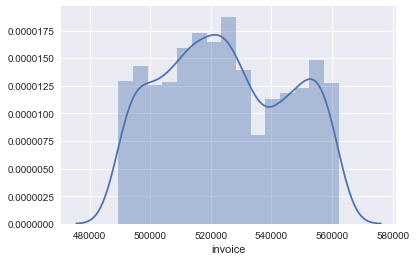

In [19]:
sns.distplot(df.invoice)

In [22]:
#Top 10 Analysis
top_10 = ['United Kingdom', 'EIRE', 'Norway', 'France',
               'Portugal', 'Germany', 'Malta', 'Sweden',
               'Singapore', 'Belgium']

In [23]:
df_top_10 = df[df['country'].isin(top_10)]
df_top_10.shape

(2289, 9)

In [24]:
df_top_10.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year
413,United Kingdom,18037.0,28,489584,11,21.95,21335,1,2017
905,United Kingdom,14865.0,28,489639,11,0.65,15036,0,2017
926,United Kingdom,13381.0,28,489634,11,1.45,21814,12,2017
1024,United Kingdom,15485.0,28,489662,11,2.95,22086,8,2017
1443,United Kingdom,15601.0,28,489611,11,2.95,21549,1,2017


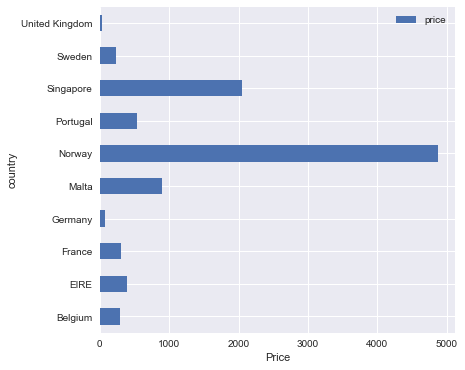

In [25]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top_10, index = ['country'], values = 'price')
table2.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Price");

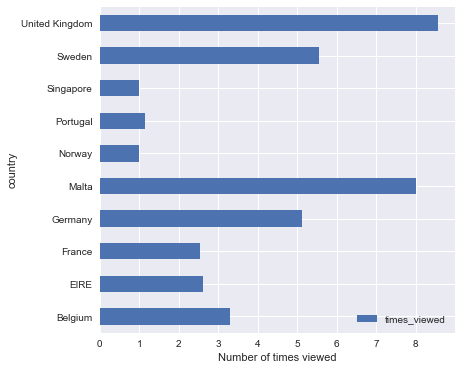

In [26]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top_10, index = ['country'], values = 'times_viewed')
table2.plot(kind='barh',ax=ax2)
ax2.set_xlabel("Number of times viewed");

(0, 9.3)

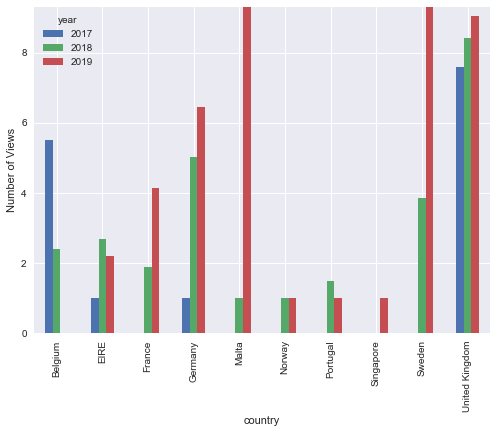

In [29]:
fig = plt.figure(figsize=(18,6))
ax2 = fig.add_subplot(121)

table2 = pd.pivot_table(df_top_10,index='country',columns='year',values="times_viewed")
table2.plot(kind='bar',ax=ax2)
ax2.set_ylabel("Number of Views");

## adjust the axis to accomadate the legend
ax2.set_ylim((0,9.3))

## Part 2

### Case study part 2

Time-series analysis is a subject area that has many varied methods and a great potential for customized solutions.
We cannot cover the breadth and depth of this important area of data science in a single case study. We do 
however want to use this as a learning opportunity if time-series analysis is new to you.  For those of you who are seasoned 
practitioners in this area, it may be a useful time to hone your skills or try out a more advanced technique like 
Gaussian processes.  The reference materials for more advanced approaches to time-series analysis will occur in their own section
below. If this is your first encounter with time-series data we suggest that that you begin with the supervised learning
approach before trying out the other possible methods. 

## Deliverable goals

1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters 
and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

## On time-series analysis

We have used TensorFlow, scikit-learn, and Spark ML as the main ways to implement models.  Time-series analysis 
has been around a long time and there are a number of specialized packages and software to help facilitate model 
implementation.  In the case of our business opportunity, it is required that we 
*predict the next point* or determine a reasonable value for next month's revenue.  If we only had revenue, we could 
engineer features with revenue for the previous day, previous week, previous month and previous three months, for example.
This provides features that machine learning models such as random forests or boosting could use to 
capture the underlying patterns or trends in the the data. You will likely spend some time optimizing this feature
engineering task on a case-by-case basis. 

Predicting the next element in a time-series is in line with the other machine learning tasks that we have encountered in
this specialization.  One caveat to this approach is that sometimes we wish to project further into the future. Although,
it is not a specific request of management in the case of this business opportunity, you may want to consider forecasting 
multiple points into the future, say three months or more. To do this, you have two main categories of methods: 'recursive forecasting' and 'ensemble forecasting'.

In recursive forecasting, you will append your predictions to the feature matrix and *roll* forward until you get to the 
desired number of forecasts in the future.  In the ensemble approach, you will use separate models for each point.  It 
is possible to use a hybridization of these two ideas as well.  If you wish to take your forecasting model to the next
level, try to project several months into the future with one or both of these ideas.

Also, be aware that the assumptions of line regression are generally invalidated when using time-series data because of auto-correlation.  The engineered features are derived mostly from revenue which often means that there is a high degree of correlation.  You will get further with more sophisticated models to in combination with smartly engineered features. 

### Data Preparation

In [55]:
#Grouping data by day for time series
df_day = df.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day['Date'] = pd.to_datetime(df_day[['year','month','day']])
df_day.head()

,year,month,day,times_viewed,price,country,Date
0,2017,11,28,33,317.25,United Kingdom,2017-11-28
1,2017,11,29,100,39.01,United Kingdom,2017-11-29
2,2017,11,30,72,22.75,United Kingdom,2017-11-30
3,2017,12,1,17,12.80,United Kingdom,2017-12-01
4,2017,12,2,22,1.97,United Kingdom,2017-12-02


In [56]:
print("Total number of days:", df_day.shape[0])

Total number of days: 467


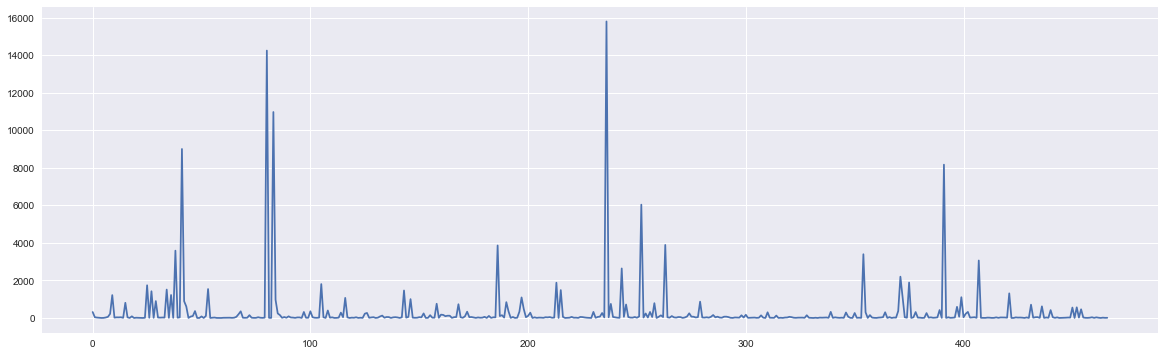

In [58]:
# checking stationarity of a time-series on a daily basis
ts_day = df_day['price']
ts_day.plot(figsize=(20, 6))

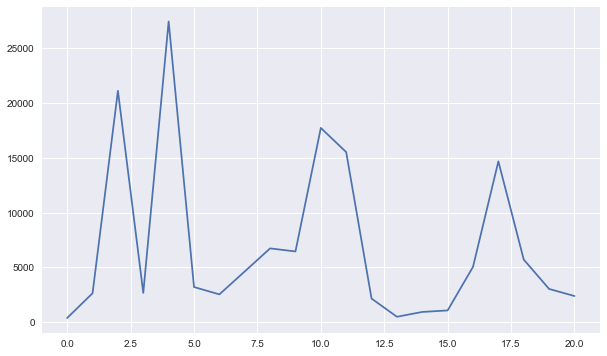

In [61]:
# checking stationarity of a time-series on a monthly basis
df_month = df.groupby(['year', 'month']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
ts_month = df_month['price']
ts_month.plot(figsize=(10, 6))

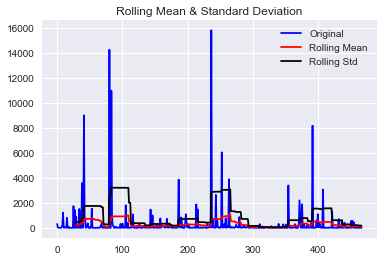

Results of Dickey-Fuller Test:
Test Statistic                -1.024300e+01
p-value                        4.695950e-18
#Lags Used                     2.000000e+00
Number of Observations Used    4.640000e+02
Critical Value (1%)           -3.444522e+00
Critical Value (5%)           -2.867789e+00
Critical Value (10%)          -2.570099e+00
dtype: float64


In [62]:
test_stationarity(ts_day)

### Forecast/Time Series

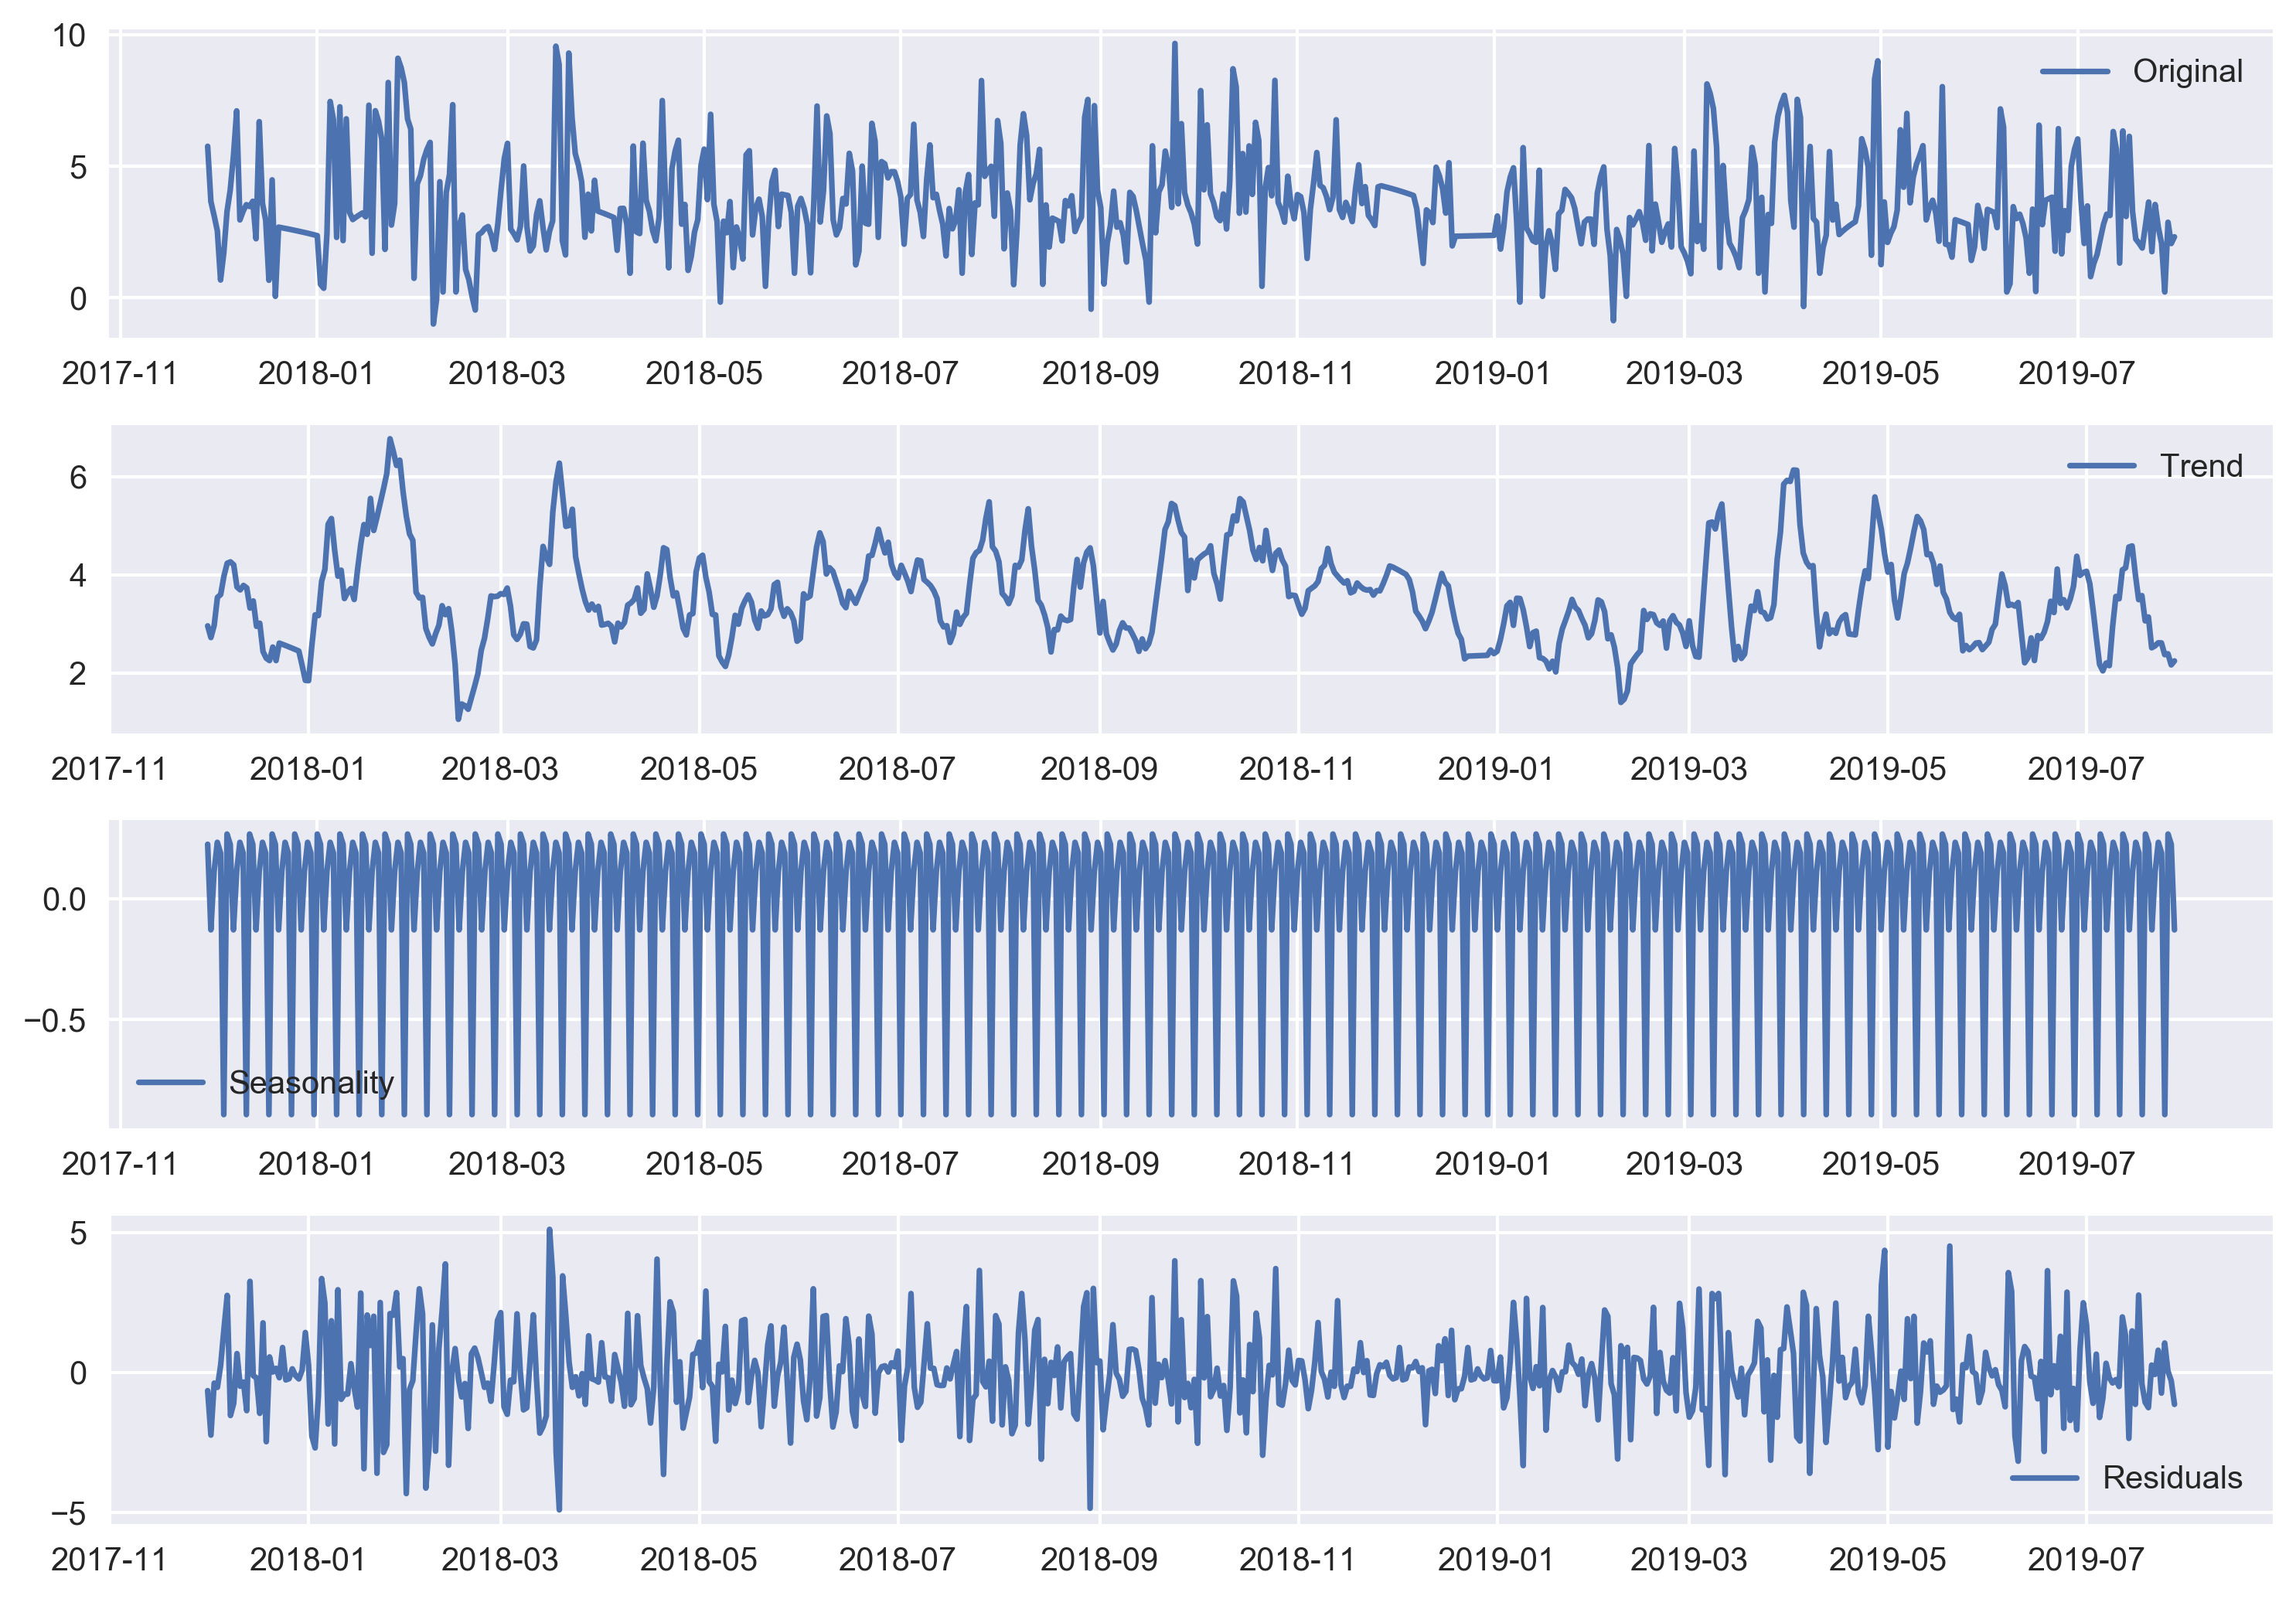

In [86]:
# Decomposing the time series into trend, seasonality and residuals 
ts = make_continuous(df_day)
trend, seasonal, residual = decompose(ts, 'price')

In [63]:
#ACF and PACF plots:
lag_acf = acf(ts_day, nlags=20)
lag_pacf = pacf(ts_day, nlags=20, method='ols')
ts_log, ts_log_diff = log_shift(ts_day, 1)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


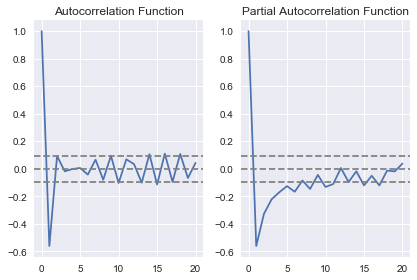

In [87]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

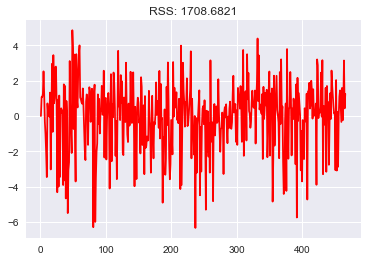

In [71]:
# AR MODEL
fit_ARIMA(ts_day, (1,1,1))